In [1]:
import torch
from bart import bart
import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tqdm import tqdm_notebook
from tqdm import tqdm
from data import transforms as T
# from train_vs_sens import create_data_loaders, build_model
from pathlib import Path
from collections import namedtuple
from torch import nn
import math
from models.models import SSIM 
ssim_loss = SSIM().cuda()


In [2]:
from train_var12_pretext_sens import create_data_loaders , build_model , load_model


In [3]:
args = {'center_fractions':[0.08],'accelerations':[4],'challenge':'singlecoil',
       'data_path':Path('/media/student1/RemovableVolume/calgary'),
        
       'resolution':170,
       'sample_rate':1,
       'batch_size':1,
        'device':'cuda',
        'data_parallel':False,
        'num_chans':32,
        'num_pools':4,
        'drop_prob':0,
        'acceleration':5,
        'dropout':0,
       }
# d_named = namedtuple("Employee", d.keys())(*d.values())
args = namedtuple('args',args.keys())(*args.values())

In [4]:
train_loader, dev_loader,display_loader = create_data_loaders(args,args.data_path)
len(train_loader)

156

In [5]:
for iter,data in enumerate(train_loader):
    ksp_us,img_us,img_us_rss,img_us_np,img_gt_np,sens,mask,maxi,fname = data
    break
ksp_us = ksp_us.to(args.device)
sens = sens.to(args.device)
mask = mask.to(args.device)
img_us = img_us.to(args.device)
img_us_rss = img_us_rss.unsqueeze(0).to(args.device).float()
img_gt_np = img_gt_np.unsqueeze(0).to(args.device).float()
img_us_np = img_us_np.unsqueeze(0).to(args.device).float()

In [ ]:
img_us_np.shape

In [ ]:
print(ksp_us.shape,img_us.shape,img_us_rss.shape,img_us_np.shape,img_gt_np.shape,sens.shape,mask.shape,maxi,fname)

In [ ]:
print(img_us.shape , img_gt_np.shape , sens.shape , fname)
print("Channel-wise US image") 
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(3, 4)
gs1.update(wspace=0.002, hspace=0.1)

for ii in range(12):
    plt.subplot(gs1[ii])
    plt.imshow(torch.sqrt(img_us[0,ii,:,:,0].detach().cpu()**2 + img_us[0,ii,:,:,1].detach().cpu()**2),cmap='gray')
#     plt.imshow(np.abs(sample_rec_train[:,:,ii]),cmap = "gray")
    plt.axis("off")
plt.show()

print("Channel-wise sensitivity maps") 
plt.figure(figsize = (8,6),dpi = 150)
gs1 = gridspec.GridSpec(3, 4)
gs1.update(wspace=0.002, hspace=0.1)

for ii in range(12):
    plt.subplot(gs1[ii])
    plt.imshow(torch.sqrt(sens[0,ii,:,:,0].detach().cpu()**2 + sens[0,ii,:,:,1].detach().cpu()**2),cmap='gray')
#     plt.imshow(np.abs(sample_rec_train[:,:,ii]),cmap = "gray")
    plt.axis("off")
    plt.colorbar()
plt.show()

# architecure_sens

In [29]:
from models.models import architecture_unet,architecture_sens
wacoeff = 0.1
dccoeff = 0.1
cascade = 12  
sens_chans = 8
sens_pools = 4

model = architecture_unet(dccoeff, wacoeff, cascade,sens_chans, sens_pools).to(args.device)
model

architecture_unet(
  (model_vs): network_unet(
    (conv_blocks): ModuleList(
      (0): NormUnet(
        (unet): UnetModel(
          (down_sample_layers): ModuleList(
            (0): ConvBlock(in_chans=2, out_chans=18, drop_prob=0)
            (1): ConvBlock(in_chans=18, out_chans=36, drop_prob=0)
            (2): ConvBlock(in_chans=36, out_chans=72, drop_prob=0)
            (3): ConvBlock(in_chans=72, out_chans=144, drop_prob=0)
          )
          (conv): ConvBlock(in_chans=144, out_chans=288, drop_prob=0)
          (up_conv): ModuleList(
            (0): ConvBlock(in_chans=288, out_chans=144, drop_prob=0)
            (1): ConvBlock(in_chans=144, out_chans=72, drop_prob=0)
            (2): ConvBlock(in_chans=72, out_chans=36, drop_prob=0)
            (3): Sequential(
              (0): ConvBlock(in_chans=36, out_chans=18, drop_prob=0)
              (1): Conv2d(18, 2, kernel_size=(1, 1), stride=(1, 1))
            )
          )
          (up_transpose_conv): ModuleList(
        

In [30]:
optimizer = torch.optim.Adam(model.parameters() , 0.001)

In [32]:
from torch.nn import functional as F
from tqdm import tqdm

epochs = 5
losses = []
# pha_loss = []

# model_pha.train()
for _ in tqdm(range(epochs)):
    
    out , _,_ = model(img_us.cuda(),ksp_us.cuda(), mask.cuda())
#     out = out.squeeze(0)
    loss = ssim_loss(out, img_us_np,torch.tensor(img_gt_np.max().item()).unsqueeze(0).cuda())
        
    losses.append(loss.item())
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    

100%|██████████| 5/5 [00:01<00:00,  3.73it/s]


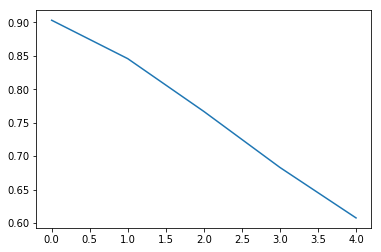

In [33]:
plt.plot(losses)

In [ ]:
out.shape

In [ ]:
out

In [ ]:
img_gt_np.shape

In [ ]:
gs1 = gridspec.GridSpec(1, 3)
plt.subplot(gs1[0])
plt.imshow(img_us_np[0,0,:,:].detach().cpu(),cmap='gray')
plt.colorbar()
plt.subplot(gs1[1])
plt.imshow(img_gt_np[0,0,:,:].detach().cpu(),cmap='gray')
plt.colorbar()
plt.subplot(gs1[2])
plt.imshow(img_us_rss[0,0,:,:].detach().cpu(),cmap='gray')
plt.colorbar()

print("us_max=",img_us_np.max(),"fs_max=",img_gt_np.max())

In [ ]:
gs1 = gridspec.GridSpec(1, 2)
plt.subplot(gs1[0])
plt.imshow(img_us_np[0,0,:,:].detach().cpu()*maxi.detach().cpu(),cmap='gray')
plt.colorbar()
plt.subplot(gs1[1])
plt.imshow(img_gt_np[0,0,:,:].detach().cpu()*maxi.detach().cpu(),cmap='gray')
plt.colorbar()

### checking on actual dataset

In [ ]:
fname_tr = '/media/student1/RemovableVolume/calgary/Train/e14140s3_P52224.7.118.h5'
with h5py.File(fname_tr, 'r') as data:

    ksp = data['kspace'][()]
    sens = data['sensitivity'][()]
ksp.shape , sens.shape

In [ ]:
img_gt_np = T.zero_filled_reconstruction(ksp)
img_gt_np.shape

In [ ]:
plt.imshow(img_gt_np,cmap='gray')
plt.colorbar()

# replacing randomly initialized layers

In [ ]:
pretext_model = '/media/student1/NewVolume/MR_Reconstruction/experiments/midl/varnet/12-channels/pretext/acc_5x/best_model.pt'
model1  = build_model(args)
_, model0,_ = load_model(pretext_model)

In [ ]:
gs1 = gridspec.GridSpec(1, 2)
plt.subplot(gs1[0])
out,out_stack,sens= model0(img_us,ksp_us,mask)
plt.imshow(out[0,0,:,:].detach().cpu().numpy())
plt.colorbar()

plt.subplot(gs1[1])
out1,out_stack1,sens1= model1(img_us,ksp_us,mask)
plt.imshow(out1[0,0,:,:].detach().cpu().numpy())
plt.colorbar()

In [ ]:
img_us_sens = T.combine_all_coils(img_us.squeeze(0),sens.squeeze(0)).unsqueeze(0)
img_us_sens.shape

In [ ]:
gs1 = gridspec.GridSpec(1, 2)
plt.subplot(gs1[0])
out = model0.model_vs.conv_blocks[0](img_us_sens)
plt.imshow(np.sqrt(out[0,:,:,0].detach().cpu().numpy()**2 + out[0,:,:,1].detach().cpu().numpy()**2))
plt.colorbar()

plt.subplot(gs1[1])
out1 = model1.model_vs.conv_blocks[0](img_us_sens)
plt.imshow(np.sqrt(out1[0,:,:,0].detach().cpu().numpy()**2 + out1[0,:,:,1].detach().cpu().numpy()**2))
plt.colorbar()

In [ ]:
# changing the weights of model0
model0.model_vs.conv_blocks[0] = model1.model_vs.conv_blocks[0]

In [ ]:
gs1 = gridspec.GridSpec(1, 2)
plt.subplot(gs1[0])
out = model0.model_vs.conv_blocks[0](img_us_sens)
plt.imshow(np.sqrt(out[0,:,:,0].detach().cpu().numpy()**2 + out[0,:,:,1].detach().cpu().numpy()**2))
plt.colorbar()

plt.subplot(gs1[1])
out1 = model1.model_vs.conv_blocks[0](img_us_sens)
plt.imshow(np.sqrt(out1[0,:,:,0].detach().cpu().numpy()**2 + out1[0,:,:,1].detach().cpu().numpy()**2))
plt.colorbar()

In [ ]:
bck = 2
for i in range(-bck,0):
    print("i=",i)
    

# submission

In [1]:
import h5py
import numpy as np
import data.transforms as T
from matplotlib import pyplot as plt
import torch
import matplotlib.gridspec as gridspec

In [15]:
data_path = "/media/student1/RemovableVolume/calgary_new/Test/test_12_channel/Test-R=5/e15274s3_P20992.7.h5"
slice = 150
with h5py.File(data_path, 'r') as data:

    zf_kspace = data['kspace'][()]
    mask_sampling = ~( np.abs(zf_kspace).sum( axis = (0, -1) ) == 0)
    mask_np = 1.0*mask_sampling
    ksp = zf_kspace[slice+50]


ksp_cmplx = ksp[:,:,::2] + 1j*ksp[:,:,1::2]
ksp_t = T.to_tensor(ksp_cmplx)
ksp_us= ksp_t.permute(2,0,1,3)
img_us = T.ifft2(ksp_us)
img_us_np = T.root_sum_of_squares(T.complex_abs(T.ifft2(ksp_us)))
img_us_np.shape

torch.Size([218, 180])

In [22]:
recons_path = '/media/student1/RemovableVolume/calgary_new/rotnet/20_volume/Track01/12-channel-R=5/e15274s3_P20992.7.h5'
with h5py.File(recons_path, 'r') as data:

    out = data['reconstruction'][()]
print("out=",out.shape)
out = out[slice,0,:,:]
# out.shape  
    

out= (156, 1, 218, 180)


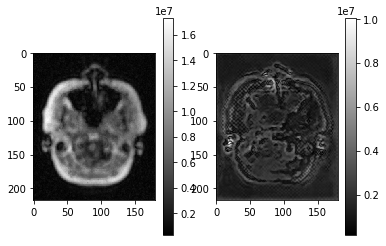

In [23]:
gs1 = gridspec.GridSpec(1, 2)
plt.subplot(gs1[0])
plt.imshow(img_us_np,cmap='gray')
plt.colorbar()

plt.subplot(gs1[1])
plt.imshow(out,cmap='gray')
plt.colorbar()

# Convdecoder

In [ ]:
slice_ksp = ksp_us

In [ ]:
ksp_cmplx = ksp_us[:,:,:,:,0].detach() + 1j*ksp_us[:,:,:,:,1]
ksp_cmplx.shape

# convdecoder setup

In [ ]:
numit = 25000
LR = 0.008

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from copy import copy

def add_module(self, module):
    self.add_module(str(len(self) + 1), module)

torch.nn.Module.add = add_module

class conv_model(nn.Module):
    def __init__(self, num_layers, strides, num_channels, num_output_channels, hidden_size, upsample_mode, act_fun,sig=None, bn_affine=True, skips=False,intermeds=None,bias=False,need_lin_comb=False,need_last=False,kernel_size=3):
        super(conv_model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.upsample_mode = upsample_mode
        self.act_fun = act_fun
        self.sig= sig
        self.skips = skips
        self.intermeds = intermeds
        self.layer_inds = [] # record index of the layers that generate output in the sequential mode (after each BatchNorm)
        self.combinations = None # this holds input of the last layer which is upsampled versions of previous layers
        
        cntr = 1
        net1 = nn.Sequential()
        for i in range(num_layers-1):
            
            net1.add(nn.Upsample(size=hidden_size[i], mode=upsample_mode))#,align_corners=True))
            cntr += 1
            
            conv = nn.Conv2d(num_channels, num_channels, kernel_size, strides[i], padding=(kernel_size-1)//2, bias=bias)
            net1.add(conv)
            cntr += 1
            
            #net1.add(nn.BatchNorm2d( num_channels, affine=bn_affine))
            net1.add(act_fun)
            cntr += 1
            
            if need_lin_comb:
                net1.add(nn.BatchNorm2d( num_channels, affine=bn_affine)) 
                #net1.add(act_fun)
                cntr += 1

                net1.add(nn.Conv2d(num_channels, num_channels, 1, 1, padding=0, bias=bias))
                cntr += 1

                #net1.add(nn.BatchNorm2d( num_channels, affine=bn_affine))
                net1.add(act_fun)
                cntr += 1
            
            #net1.add(act_fun)
            net1.add(nn.BatchNorm2d( num_channels, affine=bn_affine))
            if i != num_layers - 2: # penultimate layer will automatically be concatenated if skip connection option is chosen
                self.layer_inds.append(cntr)
            cntr += 1

        net2 = nn.Sequential()
        
        nic = num_channels
        if skips:
            nic = num_channels*( sum(intermeds)+1 )
        
        if need_last:
            net2.add( nn.Conv2d(nic, num_channels, kernel_size, strides[i], padding=(kernel_size-1)//2, bias=bias) )
            net2.add(act_fun)
            net2.add(nn.BatchNorm2d( num_channels, affine=bn_affine))
            nic = num_channels
            
        net2.add(nn.Conv2d(nic, num_output_channels, 1, 1, padding=0, bias=bias))
        
        if sig is not None:
            net2.add(self.sig)
        
        self.net1 = net1 
        self.net2 = net2
        
    def forward(self, x, scale_out=1):
        out1 = self.net1(x)
        if self.skips:
            intermed_outs = []
            for i,c in enumerate(self.net1):
                if i+1 in self.layer_inds:
                    f = self.net1[:i+1]
                    intermed_outs.append(f(x))
            intermed_outs = [intermed_outs[i] for i in range(len(intermed_outs)) if self.intermeds[i]]
            intermed_outs = [self.up_sample(io) for io in intermed_outs]
            out1 = torch.cat(intermed_outs+[out1],1)
        self.combinations = copy(out1)
        out2 = self.net2(out1)
        return out2*scale_out
    def up_sample(self,img):
        samp_block = nn.Upsample(size=self.hidden_size[-1], mode=self.upsample_mode)#,align_corners=True)
        img = samp_block(img)
        return img

def convdecoder(
        out_size = [256,256],
        in_size = [16,16],
        num_output_channels=2,
        num_layers=6,
        strides=[1]*6,
        num_channels=64,
        need_sigmoid=True, 
        pad='reflection', 
        upsample_mode='bilinear', 
        act_fun=nn.ReLU(), # nn.LeakyReLU(0.2, inplace=True) 
        bn_before_act = False,
        bn_affine = True,
        skips = True,
        intermeds=None,
        nonlin_scales=False,
        bias=False,
        need_lin_comb=False,
        need_last=False,
        kernel_size=3,
        ):
    
    
    scale_x,scale_y = (out_size[0]/in_size[0])**(1./(num_layers-1)), (out_size[1]/in_size[1])**(1./(num_layers-1))
    if nonlin_scales:
        xscales = np.ceil( np.linspace(scale_x * in_size[0],out_size[0],num_layers-1) )
        yscales = np.ceil( np.linspace(scale_y * in_size[1],out_size[1],num_layers-1) )
        hidden_size = [(int(x),int(y)) for (x,y) in zip(xscales,yscales)]
    else:
        hidden_size = [(int(np.ceil(scale_x**n * in_size[0])),
                        int(np.ceil(scale_y**n * in_size[1]))) for n in range(1, (num_layers-1))] + [out_size]
    print(hidden_size)
    if need_sigmoid:
        sig = nn.Sigmoid()
        #sig = nn.Tanh()
        #sig = nn.Softmax()
    else:
        sig = None
    
    model = conv_model(num_layers, strides, num_channels, num_output_channels, hidden_size,
                         upsample_mode=upsample_mode, 
                         act_fun=act_fun,
                         sig=sig,
                         bn_affine=bn_affine,
                         skips=skips,
                         intermeds=intermeds,
                         bias=bias,
                         need_lin_comb=need_lin_comb,
                         need_last = need_last,
                         kernel_size=kernel_size,)
    return model

In [ ]:
def num_param(net):
    s = sum([np.prod(list(p.size())) for p in net.parameters()]);
    return s

In [ ]:

x = torch.randn(15,2,320,320)
slice_ksp = x
# y.shape

In [ ]:
dtype = torch.cuda.FloatTensor
output_depth = slice_ksp.shape[0]*2
out_size = slice_ksp.shape
print("out_size",out_size)
num_channels = 160 #256
num_layers = 7
strides = [1]*(num_layers-1)
in_size = [8,4]
kernel_size = 3
parnet = convdecoder(out_size,in_size,output_depth,
                     num_layers,strides,num_channels, act_fun = nn.ReLU(),
                     skips=False,need_sigmoid=False,bias=False, need_last = True,
                     kernel_size=kernel_size,upsample_mode="nearest").type(dtype)
print(num_param(parnet))
parnet

In [ ]:
x = torch.randn(15,2,320,320)
y = parnet(x)
y.shape

# submission

In [ ]:
index = 40
slice = 50 + index
fname = '/media/student1/RemovableVolume/calgary_new/exp1/Track01/12-channel-R=5/e15790s3_P01536.7.h5'
with h5py.File(fname, 'r') as data:

    recons = data['reconstruction'][()]
recons.shape

In [ ]:
plt.imshow(recons[index,0,:,:],cmap='gray')
plt.colorbar()
print(recons.max())

In [ ]:
fname_ori = '/media/student1/RemovableVolume/calgary_new/Test/test_12_channel/Test-R=5/e15790s3_P01536.7.h5'
with h5py.File(fname_ori, 'r') as data:

            kspace = data['kspace'][slice]
            sr = 0.85
            Nz = kspace.shape[1]
            Nz_sampled = int(np.ceil(Nz*sr))

            kspace[:,Nz_sampled:,:] = 0
            ksp_cmplx = kspace[:,:,::2] + 1j*kspace[:,:,1::2]
            
ksp_cmplx.shape

In [ ]:
ksp_t = T.to_tensor(ksp_cmplx)
ksp_t = ksp_t.permute(2,0,1,3)
ksp_t.shape

In [ ]:
img_gt_np = T.root_sum_of_squares(T.complex_abs(T.ifft2(ksp_t)))
img_gt_np.shape

In [ ]:
plt.imshow(img_gt_np,cmap='gray')
plt.colorbar()
print(img_gt_np.max())

In [ ]:
def channel_wise_ifft(zero_filled_kspace):
    """
    Computes the iFFT across channels of multi-channel k-space data. The input is expected to be a complex numpy array.
    """
    return np.fft.ifft2(zero_filled_kspace, axes = (0,1))
    
    

def sum_of_squares(img_channels):
    """
    Combines complex channels with square root sum of squares. The channels are the last dimension (i.e., -1) of the input array.
    """
    return np.sqrt((np.abs(img_channels)**2).sum(axis = -1))
    return sos    

def zero_filled_reconstruction(zero_filled_kspace):
    """
    Zero-filled reconstruction of multi-channel MR images. The input is the zero-filled k-space. The channels
    are the last dimension of the array. The input may be either complex-valued or alternate between real and imaginary channels 
    in the last array dimension.
    """
    if not np.iscomplexobj(zero_filled_kspace):
        zero_filled_kspace = zero_filled_kspace[:,:,:,::2] + 1j*zero_filled_kspace[:,:,:,1::2] #convert real-imag to complex data
    
    img_gt_np = sum_of_squares(channel_wise_ifft(zero_filled_kspace))
#     img_gt_np = torch.from_numpy(img_gt_np)

    
    return img_gt_np

In [ ]:
img_np = T.zero_filled_reconstruction(ksp_cmplx)
img_np.shape

In [ ]:
plt.imshow(img_np,cmap='gray')

plt.colorbar()
print(img_np.max())

In [ ]:
img_np.max()

# Data handling

In [ ]:

fname_ori = '/media/student1/RemovableVolume/calgary/Train/e16972s3_P31232.7.99.h5'
with h5py.File(fname_ori, 'r') as data:
    ksp_gt_np = data['kspace'][()]
    sens = data['sensitivity'][()]
ksp_gt_np.shape
ksp_gt_t = T.to_tensor(ksp_gt_np)
ksp_t = ksp_gt_t.permute(2,0,1,3)
ksp_t.shape

In [ ]:
sens_t = T.to_tensor(sens)
sens_t.shape

In [ ]:
plt.imshow(np.log(np.abs(ksp_gt_np[:,:,0])+ 1e-8))
plt.colorbar()

In [ ]:
def fft2(img_t):
    """
    img_ch has shape = [ch,218,180,2] in torch tensor format
    Computes the iFFT across channels of multi-channel k-space data.
    Returns channel wise ifft in torch format.
    """
    # print("ZF",zero_filled_kspace.shape)
    img_np = img_t[:,:,:,0].numpy() + 1j*img_t[:,:,:,1].numpy()
    img_np = img_np.transpose(1,2,0)
    
    ksp_np = np.fft.fft2(img_np, axes = (0,1))
    
    ksp_t = T.to_tensor(ksp_np)
    return ksp_t.permute(2,0,1,3)


def ifft2(ksp_t):
    """
    ksp_ch has shape = [ch,218,180,2] in torch tensor format
    Computes the iFFT across channels of multi-channel k-space data.
    Returns channel wise ifft in torch format.
    """
    # print("ZF",zero_filled_kspace.shape)
    ksp_np = ksp_t[:,:,:,0].numpy() + 1j*ksp_t[:,:,:,1].numpy()
    ksp_np = ksp_np.transpose(1,2,0)
    
    img_np = np.fft.ifft2(ksp_np, axes = (0,1))
    
    img_t = T.to_tensor(img_np)
    return img_t.permute(2,0,1,3)


def root_sum_of_squares(data, dim=0):
    """
    Compute the Root Sum of Squares (RSS) transform along a given dimension of a tensor.

    Args:
        data (torch.Tensor): The input tensor
        dim (int): The dimensions along which to apply the RSS transform

    Returns:
        torch.Tensor: The RSS value
    """
    return torch.sqrt((data ** 2).sum(dim))


def complex_abs(data):
    """
    Compute the absolute value of a complex valued input tensor.

    Args:
        data (torch.Tensor): A complex valued tensor, where the size of the final dimension
            should be 2.

    Returns:
        torch.Tensor: Absolute value of data
    """
    assert data.size(-1) == 2
    return (data ** 2).sum(dim=-1).sqrt()

In [ ]:
ksp_t_np = ksp_t.numpy()
ksp_t_cmplx = ksp_t_np[:,:,:,0] + 1j*ksp_t_np[:,:,:,1]
ksp_gt_np = ksp_t_cmplx.transpose(1,2,0)
ksp_gt_np.shape

In [ ]:
img_gt_np = np.fft.ifft2(ksp_gt_np, axes = (0,1))
img_gt_np.shape
plt.imshow(np.abs(img_gt_np[:,:,0]),cmap='gray')
plt.colorbar()

In [ ]:
img = ifft2(ksp_t)
img.shape
# plt.imshow(torch.sqrt(img[0,:,:,0]**2 + img[0,:,:,1]**2))

In [ ]:
img_rss = root_sum_of_squares(complex_abs(img))
img_rss.shape

In [ ]:
plt.imshow(img_rss,cmap='gray')
plt.colorbar()

In [ ]:
img_np = T.zero_filled_reconstruction(ksp_gt_np)
img_np.shape

In [ ]:
plt.imshow(img_np,cmap='gray')
plt.colorbar()

In [ ]:
img.shape

In [ ]:
ksp = fft2(img)
ksp.shape

In [ ]:
plt.imshow(torch.log(torch.sqrt(ksp[0,:,:,0]**2 + ksp[0,:,:,1]**2) + 1e-8))
plt.colorbar()

In [ ]:
    def perform(self,out_img_cmplx,ksp,sens,mask ):
        
        x = T.complex_multiply(out_img_cmplx[...,0].unsqueeze(1), out_img_cmplx[...,1].unsqueeze(1), sens[...,0], sens[...,1])
    
        k = (torch.fft(x, 2, normalized=True)).squeeze(1)
        k_shift = T.ifftshift(k, dim=(-3,-2))

        
        sr = 0.85
        Nz = k_shift.shape[-2] 
        Nz_sampled = int(np.ceil(Nz*sr))
        k_shift[:,:,:,Nz_sampled:,:] = 0
        
        v = self.noise_lvl

        if v is not None: # noisy case
            # out = (1 - mask) * k + mask * (k + v * k0) / (1 + v)
            out = (1 - mask) * k_shift + mask * (v * k_shift + (1 - v) * ksp) 
        
        else:
           
            out = (1 - mask) * k_shift + mask * ksp
            
        
        x = torch.ifft(out, 2, normalized=True)
    
        Sx = T.complex_multiply(x[...,0], x[...,1], sens[...,0],-sens[...,1]).sum(dim=1)
        
        Ss = T.complex_multiply(sens[...,0], sens[...,1], sens[...,0],-sens[...,1]).sum(dim=1)
     
        return Sx, Ss

In [ ]:
img = ifft2(ksp_t).unsqueeze(0)
img.shape , sens_t.shape

In [ ]:
img2 = T.combine_all_coils(img.squeeze(0).float(),sens_t.float()).unsqueeze(0)
img2.shape

In [ ]:
sens2 = sens_t.unsqueeze(0)
sens2.shape

In [ ]:
x = T.complex_multiply(img2[...,0].unsqueeze(1), img2[...,1].unsqueeze(1), sens2[...,0], sens2[...,1])
x.shape

In [ ]:
plt.imshow(torch.sqrt(img2[0,:,:,0]**2 + img2[0,:,:,1]**2),cmap='gray')
plt.colorbar()

In [ ]:
plt.imshow(torch.sqrt(x[0,0,:,:,0]**2 + x[0,0,:,:,1]**2),cmap='gray')
plt.colorbar()